<a href="https://colab.research.google.com/github/aysharega/M.Tech-Project-Thesis/blob/main/CNN_leapmotion_HGR_Full_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Here we import everything we need for the project

%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.8.0


In [2]:
!pip install kaggle

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [4]:
!kaggle datasets download -d gti-upm/leapgestrecog

100% 2.13G/2.13G [00:09<00:00, 234MB/s]
100% 2.13G/2.13G [00:09<00:00, 229MB/s]


In [5]:
# Unzip images, ignore this cell if files are already in the workspace
!unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [6]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

40000


In [7]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


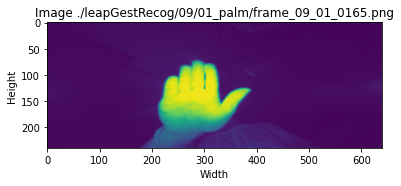

In [8]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [9]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  40000
Labels loaded:  40000
1 ./leapGestRecog/09/01_palm/frame_09_01_0165.png


In [10]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [11]:
# Recreate the exact same model, including weights and optimizer.
# model = keras.models.load_model('handrecognition_model.h5')
# model.summary()

# To use the pre-trained model, just load it and skip to the next session.

In [12]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [13]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [14]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [15]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
438/438 - 73s - loss: 1.2267 - accuracy: 0.5125 - val_loss: 0.8134 - val_accuracy: 0.5261 - 73s/epoch - 166ms/step
Epoch 2/5
438/438 - 57s - loss: 0.7753 - accuracy: 0.5365 - val_loss: 0.7740 - val_accuracy: 0.5189 - 57s/epoch - 131ms/step
Epoch 3/5
438/438 - 59s - loss: 0.7341 - accuracy: 0.5367 - val_loss: 0.7425 - val_accuracy: 0.5180 - 59s/epoch - 134ms/step
Epoch 4/5
438/438 - 57s - loss: 0.7121 - accuracy: 0.5386 - val_loss: 0.7245 - val_accuracy: 0.5106 - 57s/epoch - 130ms/step
Epoch 5/5
438/438 - 57s - loss: 0.6957 - accuracy: 0.5443 - val_loss: 0.7285 - val_accuracy: 0.5166 - 57s/epoch - 130ms/step


In [16]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

375/375 [==============================] - 11s 28ms/step - loss: 0.7285 - accuracy: 0.5166
Test accuracy: 51.66%


In [18]:
predictions = model.predict(X_test) # Make predictions towards the test set

In [19]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(0, 8)

In [20]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

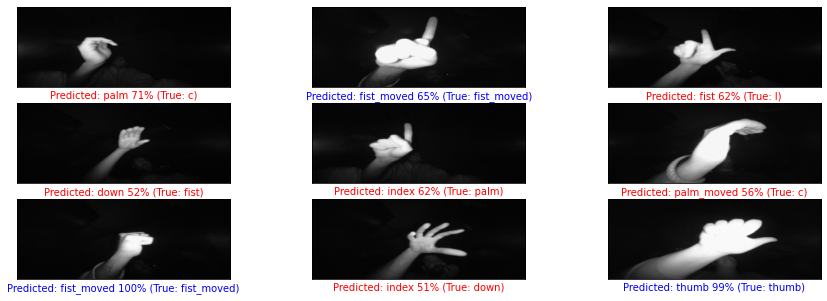

In [21]:
validate_9_images(predictions, y_test, X_test)

In [22]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [23]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,774,97,52,17,37,36,46,54,15,74
Actual Palm (H),29,875,25,34,25,39,98,35,41,20
Actual L,87,81,561,81,57,55,47,87,39,56
Actual Fist (H),122,101,52,678,32,65,49,0,47,46
Actual Fist (V),81,88,65,89,582,68,25,64,77,56
Actual Thumbs up,97,77,109,52,66,538,87,76,80,48
Actual Index,84,39,97,76,109,52,558,83,46,81
Actual OK,62,82,44,120,53,38,55,623,5,92
Actual Palm (V),101,87,63,105,48,81,93,112,398,60
Actual C,75,106,79,82,87,76,55,28,62,612
